<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Vectorized BackTesting
Backtesting is an essential part of trading. Indeed, it is important to understand the behavior of your strategy in the past to be able to consider those of future.
### Content

* Sortino Beta Alpha
* Drawdown 
* Create function BackTest to evaluate the strategy in the later sections

</br>

💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

### Environnement

In [1]:
!pip install yfinance    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# Section 1: Sortino Beta Alpha

###### Sortino
The sortino ratio is a statistic similar to the sharpe ratio with the same interpretation. However, the calculation is slightly different. Indeed, in the sortino ratio we only take into account the volatility of the negative gains because that is what we fear and not the bullish gains that make us earn money. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

*   SortinoRatio < 0 : Not profitable investissement because you gains is negative.
*   SortinoRatio < 1 : Profitable investissement but the risk of the investissement is higher than the returns.
*   SortinoRatio > 1: Very good investissement because the risk is lower than the returns.


In [3]:
# Prepare the datas 
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()
return_serie.name = "return"

# Compute the sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: 1.232


###### Beta
The beta is a statistic that indicates the relationship between the variations of our portfolio and those of the market which is represented by an index (for example SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



*   abs(Beta) < 1: It is good because it means that your portfolio have a less variation than the index. (If beta=0.9 this means that if the index varies of 1 the portfolio varies by 0.9)
*   abs(Beta) > 1: It is not a good thing because it means that your portfolio have a higher variation than the index. (If beta=1.1 this means that if the index varies of 1 the portfolio varies by 1.1)

**abs(-x) = x = abs(x) (abs gives only the value of the variable not the sign)*


In [4]:
# We need compute the covariance between the marlet and the portfolio 
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# We concate them to do the covariances
val = pd.concat((return_serie, sp500), axis=1).dropna()

# We compute beta 
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: 0.965


###### **Alpha**
Alpha is a statistic that indicates whether the portfolio outperforms the market in terms of risk return. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


*   alpha > 0: The portfolio outperforms the market in terms of risk return
*   alpha < 0: The portfolio underperforms the market in terms of risk return


In [5]:
# We compute alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: 0.9


# Section 2: Drawdown

The drawdown is a measure of the risk of the strategy. An interesting statistic to know the performance of the algorithm is the maximum drawdown. Indeed, it represents the maximum loss of a strategy over a period of time which allows you to understand if the strategy is risky and thus choose it according to your level of risk aversion.

In [6]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum() + 1

  # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown = cum/running_max - 1
  return drawdown

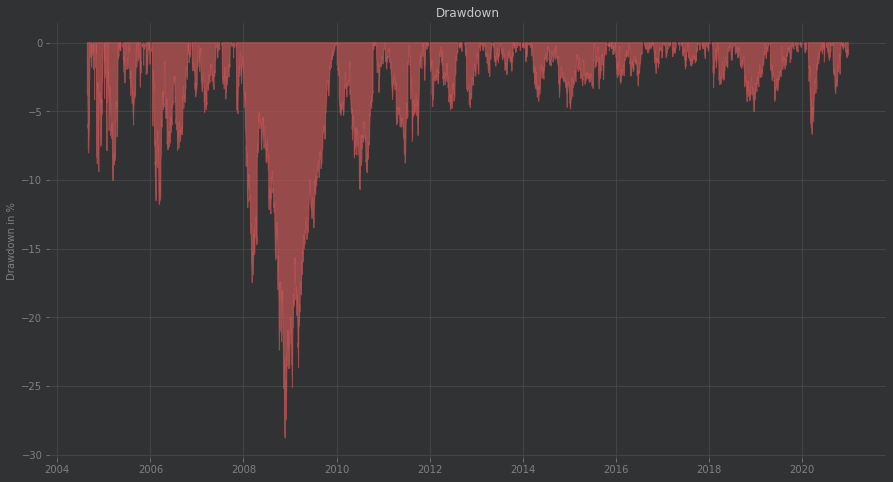

In [7]:
# We compute drawdown
drawdown = drawdown_function(return_serie)

# Adapt figure size
plt.figure(figsize=(15,8))

# Plot the drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Put a title
plt.title("Drawdown")

# Put y label
plt.ylabel("Drawdown in %")

plt.show()


In [8]:
# Computation Max drawdown
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 28.8 %


# Section 3: Create function BackTest to evaluate the strategy in the later sections

In [57]:
def BackTest(serie, annualiazed_scalar=252):
  global serie_print

  # FUNCTION TO BUT THE RIGHT DATE FORMAT
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  try:
    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  except:
    # Put the right date format
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


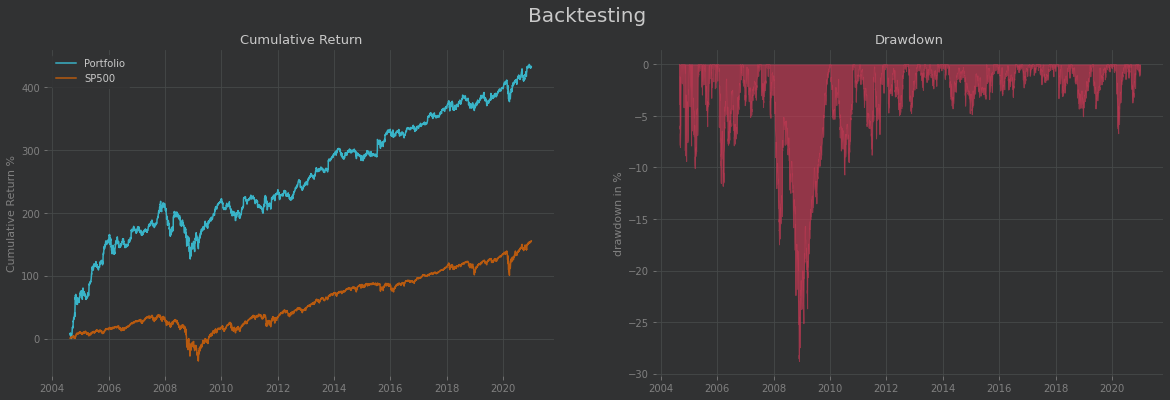

Sortino: 1.232
Beta: 0.965
Alpha: 0.918 %
MaxDrawdown: 28.78 %


In [58]:
BackTest(return_serie, 252)

##### APPLICATION

In [25]:
def preprocessing(name):

  # Import the data
  df = pd.read_csv(f"{name}", delimiter="\t", index_col="<DATE>", parse_dates=True)

  # Delete the two last columns
  df = df.iloc[:,:-2]

  # Rename
  df.columns = ["open", "high", "low", "close", "volume"]
  df.index.name = "name"

  return df
  
def breakout(df, cost=0.001, duration=7):
  df["resistance"] = df["close"].rolling(30).max().shift(3)
  df["support"] = df["close"].rolling(30).min().shift(3)

  distance = 0.5/100

  # Shift the values
  df["Close Yesterday"] = df["close"].shift(1)
  df["Resistance Yesterday"] = df["resistance"].shift(1)
  df["signal_long"] = np.nan

  df.loc[(df["close"] > df["resistance"]*(1+distance)) &\
         (df["Close Yesterday"] < df["Resistance Yesterday"]), "signal_long"] = 1

  df["signal_long"] = df["signal_long"].fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy

  df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal_long"].shift(duration))
  # df["return"] = (df["pct"] + df["pct"].shift(9) + df["pct"].shift(8) + df["pct"].shift(7) + df["pct"].shift(6)\
  #                 + df["pct"].shift(5)+ df["pct"].shift(4)+ df["pct"].shift(3)+ df["pct"].shift(2)\
  #                 + df["pct"].shift(1)) * (df["signal_long"].shift(10))
  
  df.loc[df["signal_long"]==1,"return"]=df["return"]-cost

  return df["return"]

[*********************100%***********************]  1 of 1 completed


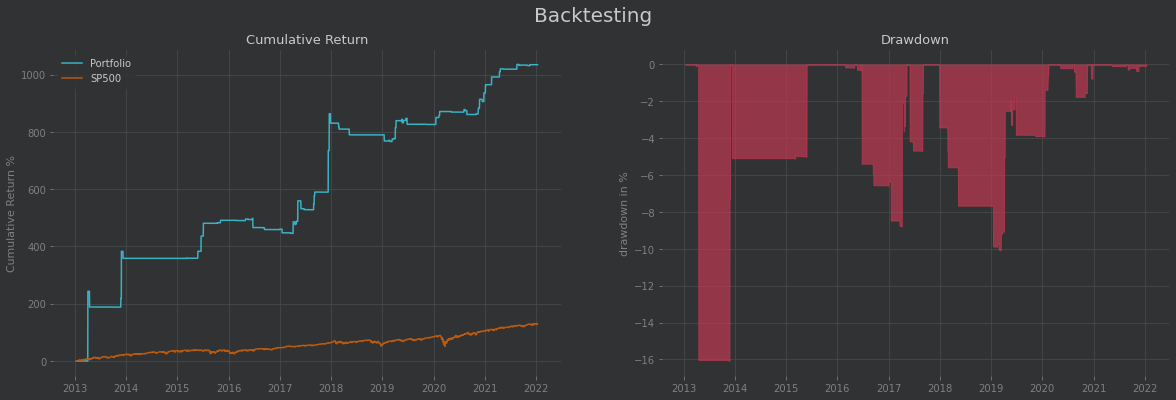

Sortino: 0.29
Beta: -0.002
Alpha: 18.078 %
MaxDrawdown: 16.081 %


In [60]:
asset = "LTC"

# Manage the data
df = preprocessing(f"{asset}USD_D1.csv")

# Create the strategy
dfc = breakout(df, duration=7)

BackTest(dfc.fillna(value=0), 52)